In [94]:
import pandas as pd
import geopandas as gpd

party_replace = {
    'PARTI KEADILAN RAKYAT (PKR)': 'PAKATAN HARAPAN (PH)',
    'PARTI TINDAKAN DEMOKRATIK (DAP)': 'PAKATAN HARAPAN (PH)',
    'PARTI ISLAM SE MALAYSIA (PAS)': 'PERIKATAN NASIONAL (PN)',
    'IKATAN DEMOKRATIK MALAYSIA (MUDA)': 'PAKATAN HARAPAN (PH)'
}

df = pd.read_csv('data/candidates_ge15.csv',usecols=['state','parlimen','party','result'])
df = df[df.result == 1].drop('result',axis=1)
df = df[~df.state.isin(['Sabah','Sarawak','W.P. Labuan'])]
df.party = df.party.map(party_replace).fillna(df.party)

vf = pd.read_csv('data/voters_ge15.csv',usecols=['state','parlimen','total'])\
    .rename(columns={'total':'voters'})\
        .groupby(['state','parlimen'])\
            .sum().reset_index()


df = pd.merge(df,vf,on=['state','parlimen'],how='left')
assert len(df[df.voters.isnull()]) == 0, 'Missing data!' # ensure complete merge

a, b = 1,300
x, y = df.voters.min(), df.voters.max()
df['voters_scaled'] = (df.voters - x) / (y - x) * (b - a) + a
df['batch'] = (df.index/5).astype(int)

geo = gpd.read_file('maps/parlimen.geojson')
geo = geo[~geo.code_state.isin([12, 13, 15])]
# geo.loc[~geo.code_state.isin([12, 13, 15]), 'geometry'] = geo.geometry.translate(9, 4.5)  # More compact Msia map
geo = pd.merge(geo, df, on=['state','parlimen'], how='left')  # Merge with election results
assert len(geo[geo.voters.isnull()]) == 0, 'Missing data!' # ensure complete merge
geo_s = geo.copy().dissolve(by='state')
geo['centre'] = geo['geometry'].centroid

C:\Users\user\AppData\Local\Temp\ipykernel_28208\1970737558.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo['centre'] = geo['geometry'].centroid


33


c:\Users\user\env_python\analysis-election-msia\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\Users\user\env_python\analysis-election-msia\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\Users\user\env_python\analysis-election-msia\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


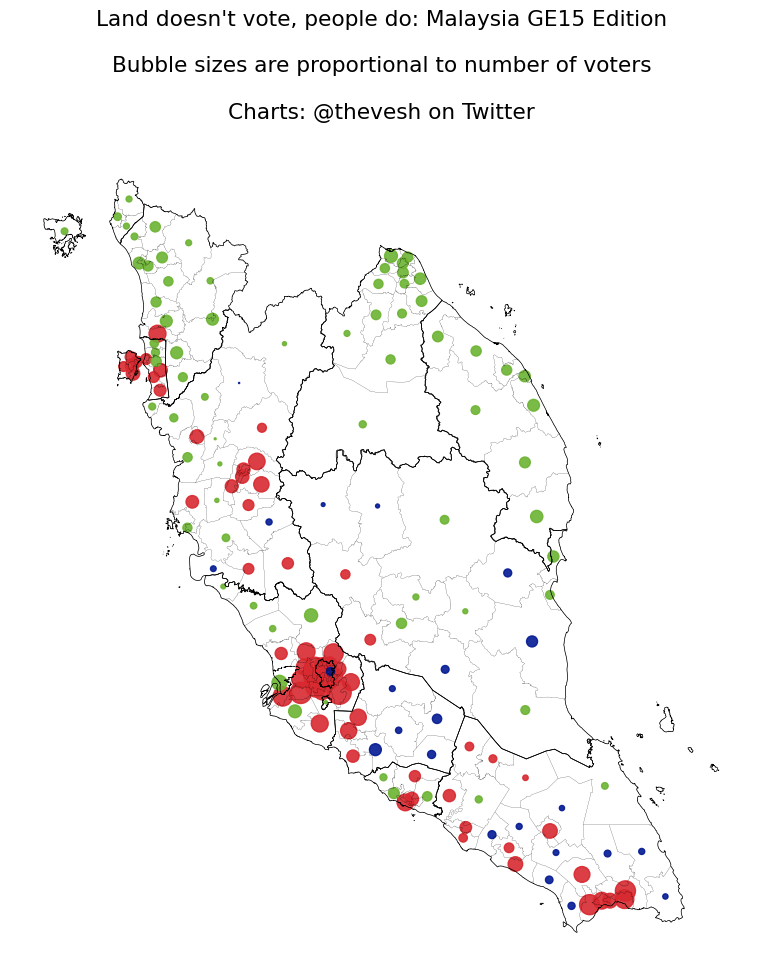

In [105]:
import matplotlib.pyplot as plt
from matplotlib import colors

party_color = { # colors from SPR dashboard
    'PAKATAN HARAPAN (PH)':'#d7292f',
    'PERIKATAN NASIONAL (PN)':'#6cb332',
    'BARISAN NASIONAL (BN)':'#031a93',
    'GABUNGAN PARTI SARAWAK (GPS)': '#1f2c45',
    'PARTI WARISAN SABAH (WARISAN)': '#5bc5f0',
    'PARTI GABUNGAN RAKYAT SABAH (GRS)': '#5bc5f0',
    'BEBAS (BEBAS)': '#000000', 
    'PARTI KESEJAHTERAAN DEMOKRATIK MASYARAKAT (KDM)': '#000000',
    'PARTI BANGSA MALAYSIA (PBM)': '#000000'
}

for b in range(df.batch.max()+1):
    print(b)

    plt.rcParams.update({'font.size': 13,
                    'font.family': 'sans-serif',
                    'grid.linestyle': 'dotted',
                    'figure.figsize': [10,10],
                    'figure.autolayout': True})
    fig, ax = plt.subplots()
    ax.axis('off')
    
    for p in list(party_color.keys())[:3]: 
        geo[(geo.party == p) & (geo.batch < b)]['centre'].plot(color=party_color[p], markersize=df[df.party == p]['voters_scaled'].tolist(), alpha=0.9, ax=ax)
        geo[(geo.party == p) & (geo.batch >= b)].plot(facecolor=party_color[p], linewidth=0.07, edgecolor='black', ax=ax, legend=True)
    geo.plot(edgecolor='black', linewidth=0.07, facecolor='none', ax=ax)
    geo_s.plot(edgecolor='black', linewidth=0.5, facecolor='none', ax=ax)
    plt.suptitle(f'Land doesn\'t vote, people do: Malaysia GE15 Edition\n\nBubble sizes are proportional to number of voters\n\nCharts: @thevesh on Twitter')
    plt.savefig(f'gif_land_v_people/chart_{b:02d}.png', bbox_inches='tight', pad_inches=0.2, dpi=400)